In [1]:
import numpy as np
import pandas as pd
import random
import math

# --------------- KiTE Imports ---------------
from KiTE.metrics import ELCE2
from KiTE.calibrate import calibrate, calibration_error
from KiTE.calibration_models import EWF_calibration, KRR_calibration

# --------------- Visualization Imports ---------------
import matplotlib.pyplot as plt  
import matplotlib.pylab as pl
import seaborn as sns
plt.style.use('tableau-colorblind10')
# sns.set()

# --------------- Model Imports ---------------
from scipy import stats
from sklearn.calibration import calibration_curve
from sklearn.metrics import pairwise_distances, pairwise_kernels, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import (
    LinearRegression,
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
    Ridge
)
from sklearn.pipeline import make_pipeline

# Load Data
* COMPAS Data can be found at [this source](https://github.com/propublica/compas-analysis/blob/master/compas.db)
* We use Broward Data from 2013 - 2014, inclusive. 

In [2]:
def load_recidivism_data(file_name = 'BROWARD_ORIGINAL.csv'):
    df = pd.read_csv(file_name)[
        [
            "sex",
            "age",
            "race",
            "juv_fel_count",
            "juv_misd_count",
            "priors_count",
            "c_charge_degree",
            "is_recid",
        ]
    ]

    df["c_charge_degree"].replace(["F", "M"], [0, 1], inplace=True)
    df["sex"].replace(["Male", "Female"], [0, 1], inplace=True)
    df["age"] /= 10.0

    # Get one hot encoding of columns B
    one_hot = pd.get_dummies(df["race"])
    
    # Drop column B as it is now encoded
    df = df.drop("race", axis=1)
    
    # Join the encoded df
    df = df.join(one_hot)

    return df

In [3]:
df = load_recidivism_data()
df

,sex,age,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_recid,African-American,Asian,Caucasian,Hispanic,Native American,Other
0,0,6.9,0,0,0,0,0,0,0,0,0,0,1
1,0,3.4,0,0,0,0,1,1,0,0,0,0,0
2,0,2.4,0,0,4,0,1,1,0,0,0,0,0
3,0,2.3,0,1,1,0,0,1,0,0,0,0,0
4,0,4.3,0,0,2,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0,2.3,0,0,0,0,0,1,0,0,0,0,0
7210,0,2.3,0,0,0,0,0,1,0,0,0,0,0
7211,0,5.7,0,0,0,0,0,0,0,0,0,0,1
7212,1,3.3,0,0,3,1,0,1,0,0,0,0,0


# Build Random Forest Classification Model
* Split data into train-validate-test disjoint sets
    * Train -- Used to train the Random Forest Classifier
    * Validate -- Used to train model calibration
    * Test -- Used to test group-wise trustworthiness

In [4]:
def build_model(df):
    features = [
        "age",
        "sex",
        "African-American",
        "juv_fel_count",
        "juv_misd_count",
        "priors_count",
        "c_charge_degree",
        "Asian",
        "Caucasian",
        "Hispanic",
        "Native American",
        "Other",
    ]
    fair_features = ["age", "sex", "African-American"]
    target = "is_recid"

    # Split data into train, validate and test data
    train, validate, test = np.split(
        df.sample(frac=1), [int(0.33 * len(df)), int(0.66 * len(df))]
    )

    X_train = np.array(train[features])
    X_cv = np.array(validate[features])
    X_test = np.array(test[features])

    X_train_fair = np.array(train[fair_features])
    X_cv_fair = np.array(validate[fair_features])
    X_test_fair = np.array(test[fair_features])

    y_train = np.array(train[target])
    y_cv = np.array(validate[target])
    y_test = np.array(test[target])

    # Train the Random Forest model on the 1st subset of data (training set)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    prob_test = clf.predict_proba(X_test)[:, 1]
    prob_cv = clf.predict_proba(X_cv)[:, 1]

    return X_test, X_test_fair, y_test, X_cv, X_cv_fair, y_cv, prob_test, prob_cv, clf

In [5]:
(
    X_test,
    X_test_fair,
    y_test,
    X_cv,
    X_cv_fair,
    y_cv,
    prob_test,
    prob_cv,
    clf,
) = build_model(df)

# Compare Calibration Methods

In [6]:
def plot_metrics(
    X_test,
    prob_test,
    y_test,
    X_cv,
    prob_cv,
    y_cv,
    method,
    ax1,
    ax2,
    ax3,
    ax4,
    ax5,
    ax6,
    legend=None,
    n_bins=20,
    prob_kernel_wdith=0.05,
    gamma=0.5,
    marker="^",
    markersize=14,
    multiplier=100.0,
    markeredgewidth=2,
    data=False,
    **kwargs
):

    import time

    # ------------- RUN CALIBRATION -------------
    prob_cal = prob_test.copy() if method == "No calibration" else calibrate(X_cv,prob_cv,y_cv,Xtest=X_test,prob_test=prob_test,method=method,gamma=gamma) if method == "EWF" or method == "KRR" else calibrate(X_cv,prob_cv,y_cv,Xtest=X_test,prob_test=prob_test,method=method,**kwargs)

    X_test = X_test[0 <= prob_cal]
    y_test = y_test[0 <= prob_cal]
    prob_cal = prob_cal[0 <= prob_cal]
    
    X_test = X_test[1 >= prob_cal]
    y_test = y_test[1 >= prob_cal]
    prob_cal = prob_cal[1 >= prob_cal]


    # ------------- MAKE CALIBRATION CURVE + CREATE SCORES -------------
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, prob_cal, n_bins=n_bins
    )
    BS_score = calibration_error(y_test, prob_cal, n_bins=n_bins, method="BS")
    ece_score = calibration_error(y_test, prob_cal, n_bins=n_bins, method="ECE")
    mce_score = calibration_error(y_test, prob_cal, n_bins=n_bins, method="MCE")
    
    start_time = time.time()
    if data:
        ELCE2_ = ELCE2(
            X_test,
            y_test,
            prob_cal,
            prob_kernel_width=prob_kernel_wdith,
            kernel_function="rbf",
            gamma=gamma,
            iterations=None,
            verbose=False,
        )
    else:
        ELCE2_, _, pvalue = ELCE2(
            X_test,
            y_test,
            prob_cal,
            kernel_function="rbf",
            prob_kernel_width=prob_kernel_wdith,
            iterations=1000,
            verbose=True,
            gamma=gamma,
        )
    print("--- TIME_TAKEN = %s seconds ---" % (time.time() - start_time))
        
        
    if data:
        return BS_score, ece_score, mce_score, ELCE2_

    if pvalue > 0.49:
        pvalue = 0.49
    if ELCE2_ < 0.0:
        ELCE2_ = -0.00005

        
    # ------------- GENERATE PLOT -------------    
    ax1.plot(
        mean_predicted_value,
        fraction_of_positives,
        "%s-" % marker,
        markersize=markersize - 6,
        lw=3.0,
        label=legend,
    )
    ax2.plot(
        BS_score, 1, marker, markersize=markersize, markeredgewidth=markeredgewidth
    )
    ax3.plot(
        ece_score, 1, marker, markersize=markersize, markeredgewidth=markeredgewidth
    )
    ax4.plot(
        mce_score, 1, marker, markersize=markersize, markeredgewidth=markeredgewidth
    )
    ax5.plot(ELCE2_, 1, marker, markersize=markersize, markeredgewidth=markeredgewidth)
    ax6.plot(pvalue, 1, marker, markersize=markersize, markeredgewidth=markeredgewidth)

    print(
        legend
        + " "
        + method
        + " BS : %0.3f " % BS_score
        + " ECE : %0.3f " % ece_score
        + " MCE : %0.3f " % mce_score
        + " ELCE2 : %0.3f" % (ELCE2_)
    )
    time.sleep(1)


In [7]:
# Trains the model 
def predicting_recidivism_callib(df):
    np.random.seed(1864)

    # kernel hyperparameter
    gamma = 0.5  # np.median(pairwise_distances(X_test, metric='euclidean')) ** 2

    # error calibration setup
    n_bins = 20

    # #############################################################################
    # Plot calibration plots
    methods = ['No calibration', 'platt', 'temperature_scaling', 'isotonic', 'BBQ', 'EWF', 'KRR']

    l_methods = len(methods)
    plt.figure(figsize=(l_methods * 5, 11))

    for i, method in enumerate(methods):

        ax1 = plt.subplot2grid((9, l_methods * 1), (0, i), rowspan=4)
        ax2 = plt.subplot2grid((9, l_methods * 1), (4, i))
        ax3 = plt.subplot2grid((9, l_methods * 1), (5, i))
        ax4 = plt.subplot2grid((9, l_methods * 1), (6, i))
        ax5 = plt.subplot2grid((9, l_methods * 1), (7, i))
        ax6 = plt.subplot2grid((9, l_methods * 1), (8, i))

        ax1.plot([0, 1], [0, 1], "k:", label="reference")

        plot_metrics(X_test_fair, prob_test, y_test, X_cv_fair, prob_cv, y_cv, method, ax1, ax2, ax3, ax4, ax5, ax6,
                     legend="Recidivism Pred.", n_bins=20, prob_kernel_wdith=0.1, gamma=gamma, marker='^',
                     markersize=17, markeredgewidth=2)

        ax1.set_xlabel("Mean predicted value", size=18)
        ax1.set_ylim([0.0, 1.])
        ax1.set_xlim([0.0, 1.])
        ax1.set_title(method, size=20)
        ax1.grid()

        ax2.set_yticks([])
        ax2.set_xlim([0.0, 0.5])
        ax3.set_yticks([])
        ax3.set_xlim([0, 0.102])
        ax4.set_yticks([])
        ax4.set_xlim([0, 0.4])
        ax5.set_yticks([])
        ax5.set_xlim([-0.0005, 0.042])
        ax6.set_yticks([])
        ax6.set_xlim([-0.01, 0.5])

        if i == 0:
            ax1.set_ylabel("Fraction of positives", size=18)
            ax1.legend(loc="upper left", prop={'size': 13})
            ax2.set_ylabel("BS", size=18)
            ax3.set_ylabel("ECE", size=18)
            ax4.set_ylabel("MCE", size=18)
            ax5.set_ylabel(r"ELCE$^2_{u}$", size=18)
            ax6.set_ylabel(r"p-val", size=18)

    plt.tight_layout()
    plt.savefig('./NEW_recidivism_test.png', bbox_inches='tight')
    plt.show()


/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


--- TIME_TAKEN = 26.660098791122437 seconds ---
Recidivism Pred. No calibration BS : 0.259  ECE : 0.158  MCE : 0.373  ELCE2 : 0.032


/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


--- TIME_TAKEN = 27.696709871292114 seconds ---
Recidivism Pred. platt BS : 0.230  ECE : 0.033  MCE : 0.052  ELCE2 : 0.001


/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


--- TIME_TAKEN = 28.188889026641846 seconds ---
Recidivism Pred. temperature_scaling BS : 0.240  ECE : 0.094  MCE : 0.202  ELCE2 : 0.005


/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


--- TIME_TAKEN = 28.086582899093628 seconds ---
Recidivism Pred. isotonic BS : 0.231  ECE : 0.030  MCE : 0.126  ELCE2 : 0.001


100%|███████████████████████████████████████| 134/134 [00:00<00:00, 2062.77it/s]
/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


--- TIME_TAKEN = 28.311749935150146 seconds ---
Recidivism Pred. BBQ BS : 0.231  ECE : 0.024  MCE : 0.200  ELCE2 : 0.002


/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


--- TIME_TAKEN = 28.304991960525513 seconds ---
Recidivism Pred. EWF BS : 0.253  ECE : 0.139  MCE : 0.281  ELCE2 : 0.026


/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


--- TIME_TAKEN = 28.772603034973145 seconds ---
Recidivism Pred. KRR BS : 0.226  ECE : 0.035  MCE : 0.226  ELCE2 : 0.000


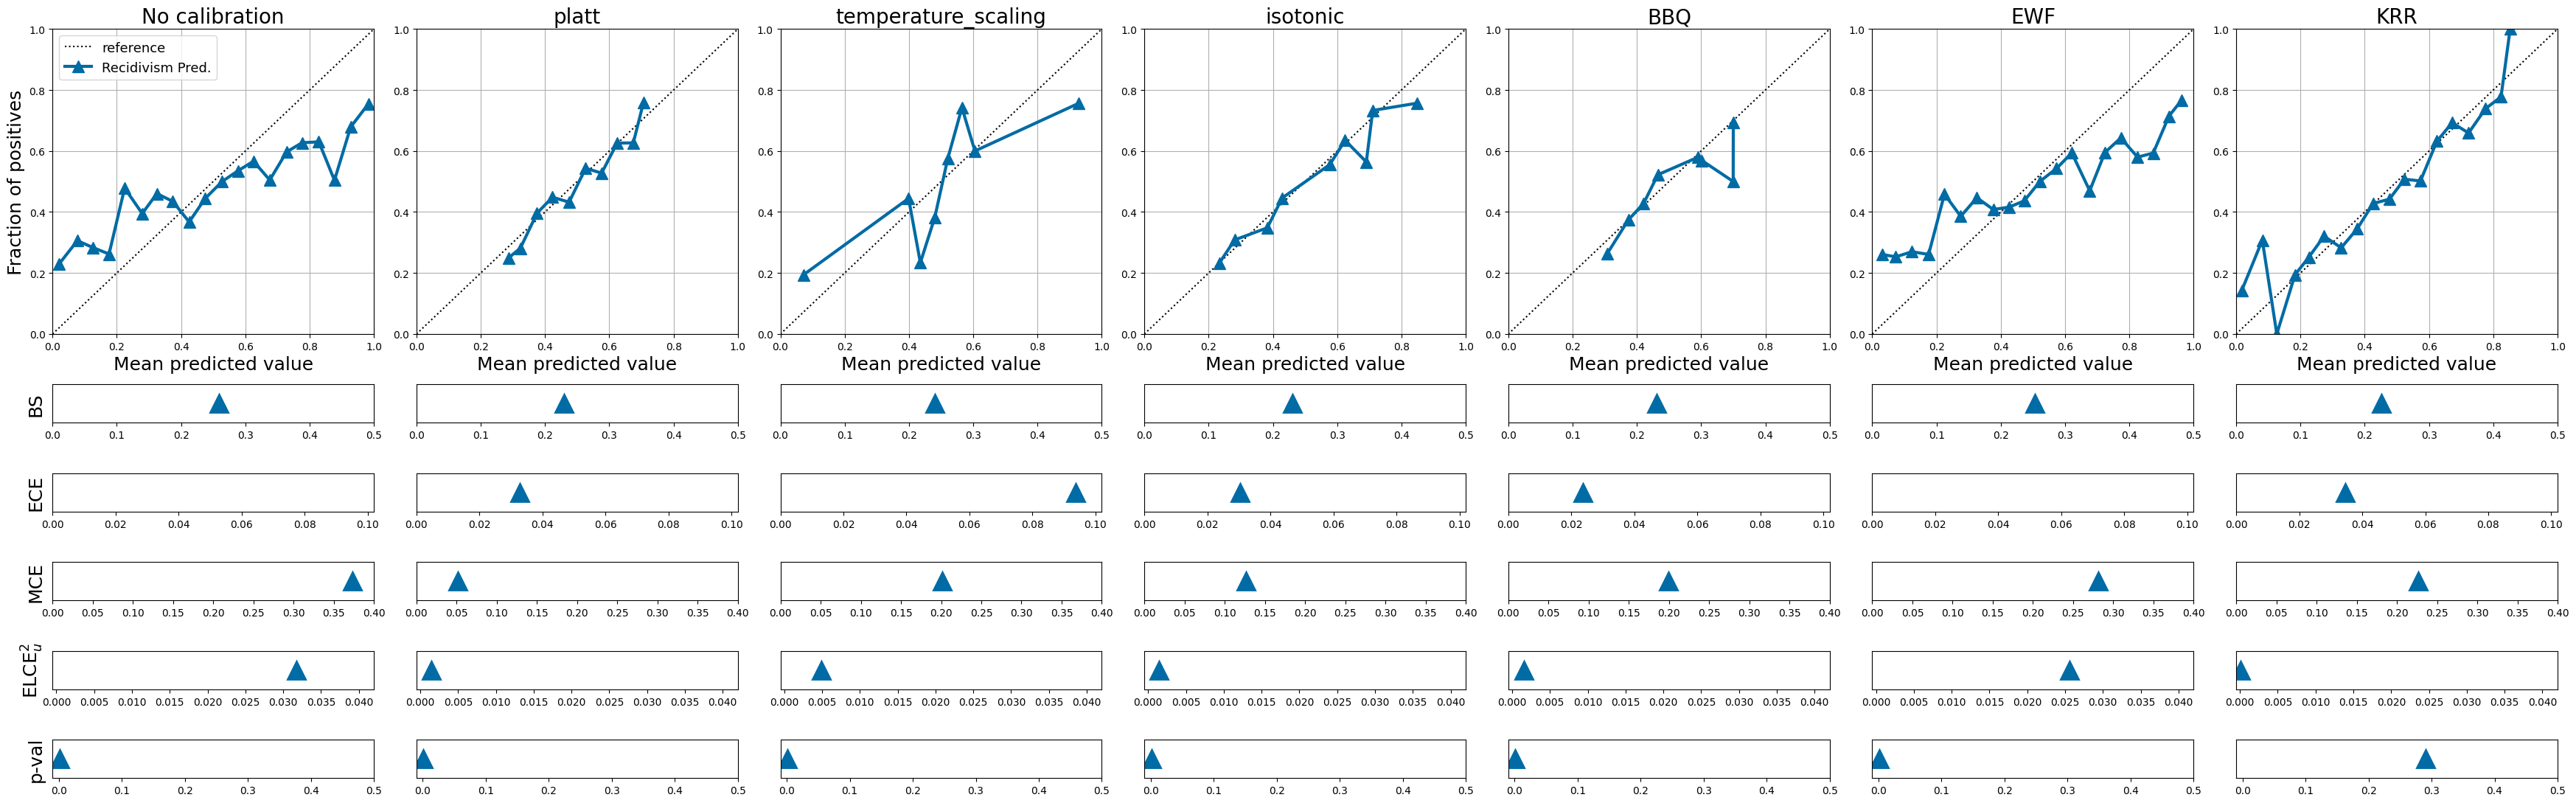

In [8]:
predicting_recidivism_callib(df)

# Plot EWF Estimated Bias

In [9]:
def predicting_recidivism():
    np.random.seed(1864)

    # kernel hyperparameter
    gamma = 0.5

    # error calibration setup
    n_bins = 20
    kmax = 1
    ewf_model = EWF_calibration()

    # #############################################################################
    #                             Plot calibration plots
    # #############################################################################
    def plot_ewf(X_cv, y_cv, prob_cv, X_test, prob_test, ax, color="blue", label=None):
        # Train a calibration method (EWF) on 2nd data subset
        ewf_model.fit(X_cv, prob_cv, y_cv, kernel_function="rbf", gamma=gamma)
        ewf = ewf_model.predict(X_test, prob_test, mode="bias")
        
        # Plot outcome
        ax.plot(
            X_test.T[0] * 10 + 0.3 * (np.random.random() - 0.5), ewf, ".", color=color
        )

        Xfit = X_test.T[0] * 10
        model = make_pipeline(PolynomialFeatures(3), Ridge())
        model.fit(Xfit[:, np.newaxis], ewf)

        X_plot = np.linspace(20, 70, 201)
        y_plot = model.predict(X_plot[:, np.newaxis])

        ax.plot(X_plot, y_plot, lw=5, color=color, label=label)
        return ax

    
    plt.figure(figsize=(2 * 7, 6))
    ax = plt.subplot2grid((2, 2), (0, 0))
    ax.plot([20.0, 70.0], [0, 0], "k-", label="reference")

    mask = X_test_fair.T[1] == 0
    mask *= X_test_fair.T[2] == 1
    ax = plot_ewf(
        X_cv_fair,
        y_cv,
        prob_cv,
        X_test_fair[mask],
        prob_test[mask],
        ax,
        color="#377eb8",
        label="Male",
    )

    mask = X_test_fair.T[1] == 1
    mask *= X_test_fair.T[2] == 1
    ax = plot_ewf(
        X_cv_fair,
        y_cv,
        prob_cv,
        X_test_fair[mask],
        prob_test[mask],
        ax,
        color="#f781bf",
        label="Female",
    )

    ax.set_ylim([-0.1, 0.1])
    plt.yticks([-0.1, -0.05, 0, 0.05, 0.1], ["-0.1", "-0.05", "0", "0.05", "0.1"])
    ax.set_xlim([20, 70.0])

    ax.set_title(r"African-American", size=25, color="indianred")
    ax.set_ylabel("Risk Prediction Bias", size=24)
    ax.set_xlabel(r"Age [years]", size=27)

    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.tick_params(axis="both", which="minor", labelsize=15)
    ax.legend(loc="upper right", prop={"size": 17})

    ax.grid()
    ax = plt.subplot2grid((2, 2), (0, 1))
    ax.plot([20.0, 70.0], [0, 0], "k-", label="reference")

    mask = X_test_fair.T[1] == 0
    mask *= X_test_fair.T[2] == 0
    ax = plot_ewf(
        X_cv_fair,
        y_cv,
        prob_cv,
        X_test_fair[mask],
        prob_test[mask],
        ax,
        color="#377eb8",
        label="Male",
    )

    mask = X_test_fair.T[1] == 1
    mask *= X_test_fair.T[2] == 0
    ax = plot_ewf(
        X_cv_fair,
        y_cv,
        prob_cv,
        X_test_fair[mask],
        prob_test[mask],
        ax,
        color="#f781bf",
        label="Female",
    )

    ax.set_ylim([-0.1, 0.1])
    plt.yticks([-0.1, -0.05, 0, 0.05, 0.1], 5 * [""])
    ax.set_xlim([20, 70.0])

    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.tick_params(axis="both", which="minor", labelsize=15)

    ax.set_xlabel(r"Age [years]", size=27)
    ax.set_title(r"Non-African-American", size=25, color="indianred")

    ax.grid()

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.02)
    plt.savefig("./NEW_recidivism_test_bias.png", bbox_inches="tight")
    plt.show()

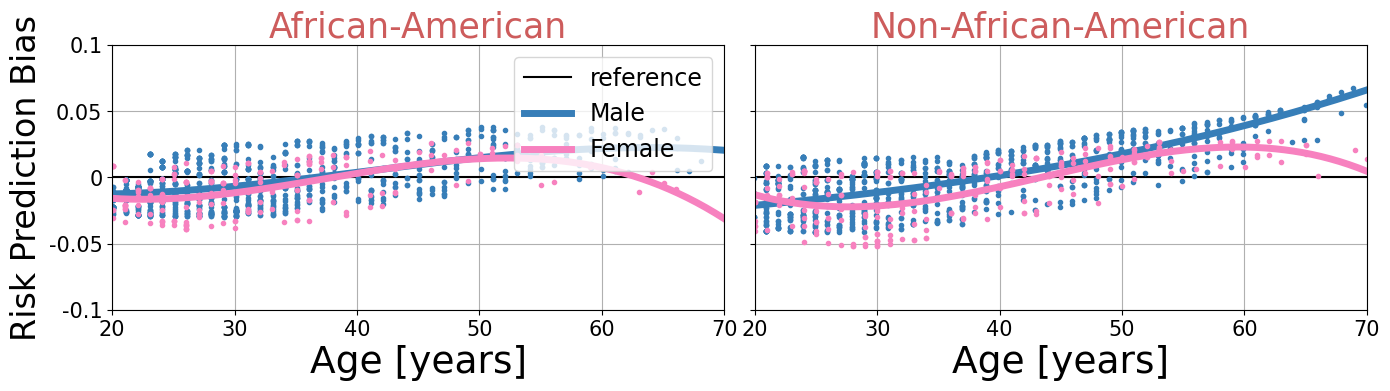

In [10]:
predicting_recidivism()